# VAE Latent Space Playground 🎮

This notebook provides an interactive environment for exploring VAE latent spaces, visualizing ELBO components, and experimenting with different VAE configurations.

## 📚 What You'll Learn
- How to load and interact with trained VAE models
- Explore latent space through traversals and interpolations
- Understand ELBO decomposition (reconstruction + KL divergence)
- Compare different sampling strategies
- Visualize the learned latent representations


## 🔧 Setup


In [1]:
# Import necessary libraries
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output

# Add src to path
sys.path.append('../')

from src.eval import load_model_from_checkpoint
from src.dataset import get_sample_images
from src.visualize import create_latent_traversal, create_reconstruction_grid
from src.sample import sample_from_prior, interpolate_between_samples
from src.losses import elbo_loss

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

%matplotlib inline
%load_ext autoreload
%autoreload 2


## 🚀 Load Trained VAE Model


In [2]:
# Configuration
CHECKPOINT_PATH = "../outputs/ckpts/best.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

# Load model
try:
    model, config = load_model_from_checkpoint(CHECKPOINT_PATH, device)
    print(f"✅ Model loaded successfully!")
    print(f"Model: {model.__class__.__name__}")
    print(f"Dataset: {config.data.dataset}")
    print(f"Latent dimensions: {model.latent_dim}")
    print(f"Input channels: {config.model.in_ch}")
except FileNotFoundError:
    print(f"❌ Checkpoint not found: {CHECKPOINT_PATH}")
    print(f"💡 Please train a model first using: python -m src.cli train --config configs/mnist.yaml")
    model, config = None, None
except Exception as e:
    print(f"❌ Error loading model: {e}")
    model, config = None, None


Using device: cuda
✅ Model loaded successfully!
Model: VAEConv
Dataset: mnist
Latent dimensions: 32
Input channels: 1


## 📊 Load Sample Data


Sample images shape: torch.Size([64, 1, 28, 28])


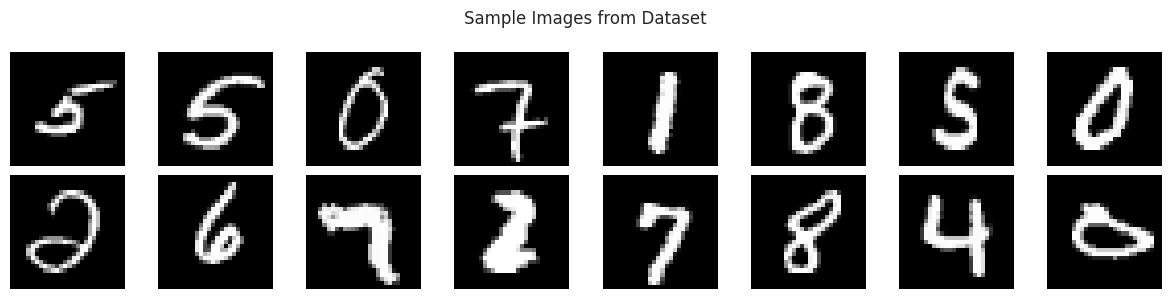

In [3]:
if model is not None and config is not None:
    # Load sample images
    sample_images = get_sample_images(
        config.data.dataset,
        config.data.root,
        num_samples=64,
        normalize=config.data.normalize
    )
    
    print(f"Sample images shape: {sample_images.shape}")
    
    # Display a few sample images
    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    for i in range(16):
        row, col = i // 8, i % 8
        img = sample_images[i].squeeze().cpu().numpy()
        axes[row, col].imshow(img, cmap='gray' if config.model.in_ch == 1 else None)
        axes[row, col].axis('off')
    
    plt.suptitle('Sample Images from Dataset')
    plt.tight_layout()
    plt.show()
else:
    print("⏭️ Skipping data loading (model not available)")


## 🔄 Interactive Reconstruction Comparison


In [ ]:
if model is not None:
    def show_reconstruction(image_idx=0):
        """Show original vs reconstructed image."""
        with torch.no_grad():
            model.eval()
            
            # Get original image
            original = sample_images[image_idx:image_idx+1].to(device)
            
            # Get reconstruction
            reconstruction = model.reconstruct(original)
            
            # Compute ELBO components
            x_hat, mu, logvar = model(original)
            _, loss_dict = elbo_loss(x_hat, original, mu, logvar, beta=1.0, 
                                   recon_loss_type=config.train.recon_loss)
            
            # Display
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            
            # Original
            orig_img = original.squeeze().cpu().numpy()
            axes[0].imshow(orig_img, cmap='gray' if config.model.in_ch == 1 else None)
            axes[0].set_title('Original')
            axes[0].axis('off')
            
            # Reconstruction
            if hasattr(model, 'decoder') and hasattr(model.decoder, 'deconv_layers'):
                recon_img = torch.sigmoid(reconstruction).squeeze().cpu().numpy()
            else:
                recon_img = reconstruction.squeeze().cpu().numpy()
            
            axes[1].imshow(recon_img, cmap='gray' if config.model.in_ch == 1 else None)
            axes[1].set_title('Reconstruction')
            axes[1].axis('off')
            
            # Add loss information
            plt.suptitle(f'Recon Loss: {loss_dict["recon_loss"].item():.3f}, '
                        f'KL Loss: {loss_dict["kl_loss"].item():.3f}, '
                        f'Total: {loss_dict["total_loss"].item():.3f}')
            
            plt.tight_layout()
            plt.show()
            
            # Show latent statistics
            print(f"Latent statistics:")
            print(f"  Mean (μ): min={mu.min().item():.3f}, max={mu.max().item():.3f}, std={mu.std().item():.3f}")
            print(f"  Log-var: min={logvar.min().item():.3f}, max={logvar.max().item():.3f}, mean={logvar.mean().item():.3f}")
            print(f"  Std (σ): min={torch.exp(0.5*logvar).min().item():.3f}, max={torch.exp(0.5*logvar).max().item():.3f}")
    
    # Interactive widget
    interact(show_reconstruction, image_idx=widgets.IntSlider(
        value=0, min=0, max=len(sample_images)-1, step=1, description='Image:'))
        
else:
    print("⏭️ Skipping reconstruction demo (model not available)")


## 🎚️ Interactive Latent Space Traversal


In [4]:
if model is not None:
    def traverse_latent_space(image_idx=0, dim=0, num_steps=11, step_size=3.0):
        """Interactive latent space traversal."""
        if dim >= model.latent_dim:
            print(f"⚠️ Dimension {dim} is out of range. Model has {model.latent_dim} dimensions.")
            return
            
        base_image = sample_images[image_idx:image_idx+1].to(device)
        
        # Create traversal
        traversal = create_latent_traversal(
            model, base_image, device, dim, num_steps, step_size
        )
        
        # Display traversal
        fig, axes = plt.subplots(1, num_steps, figsize=(2*num_steps, 2))
        if num_steps == 1:
            axes = [axes]
            
        traverse_values = np.linspace(-step_size, step_size, num_steps)
        
        for i in range(num_steps):
            img = traversal[i].squeeze().cpu().numpy()
            axes[i].imshow(img, cmap='gray' if config.model.in_ch == 1 else None)
            axes[i].set_title(f'{traverse_values[i]:.1f}')
            axes[i].axis('off')
        
        plt.suptitle(f'Latent Traversal - Dimension {dim}')
        plt.tight_layout()
        plt.show()
    
    # Interactive widget
    interact(traverse_latent_space, 
             image_idx=widgets.IntSlider(value=0, min=0, max=len(sample_images)-1, description='Image:'),
             dim=widgets.IntSlider(value=0, min=0, max=min(model.latent_dim-1, 15), description='Dimension:'),
             num_steps=widgets.IntSlider(value=11, min=3, max=15, description='Steps:'),
             step_size=widgets.FloatSlider(value=3.0, min=0.5, max=5.0, step=0.5, description='Range:'))
             
else:
    print("⏭️ Skipping latent traversal demo (model not available)")


interactive(children=(IntSlider(value=0, description='Image:', max=63), IntSlider(value=0, description='Dimens…

## 🎲 Interactive Prior Sampling


In [ ]:
if model is not None:
    def sample_from_prior_interactive(num_samples=16, temperature=1.0, seed=42):
        """Generate samples from prior with different temperatures."""
        torch.manual_seed(seed)
        
        samples = sample_from_prior(model, num_samples, device, temperature)
        
        # Display samples
        grid_size = int(np.ceil(np.sqrt(num_samples)))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(2*grid_size, 2*grid_size))
        
        if grid_size == 1:
            axes = [[axes]]
        elif len(axes.shape) == 1:
            axes = [axes]
        
        for i in range(grid_size):
            for j in range(grid_size):
                idx = i * grid_size + j
                if idx < num_samples:
                    img = samples[idx].squeeze().cpu().numpy()
                    axes[i][j].imshow(img, cmap='gray' if config.model.in_ch == 1 else None)
                axes[i][j].axis('off')
        
        plt.suptitle(f'Samples from Prior (Temperature: {temperature})')
        plt.tight_layout()
        plt.show()
    
    # Interactive widget
    interact(sample_from_prior_interactive,
             num_samples=widgets.IntSlider(value=16, min=4, max=64, step=4, description='# Samples:'),
             temperature=widgets.FloatSlider(value=1.0, min=0.1, max=2.0, step=0.1, description='Temperature:'),
             seed=widgets.IntSlider(value=42, min=0, max=9999, description='Seed:'))
             
else:
    print("⏭️ Skipping prior sampling demo (model not available)")


interactive(children=(IntSlider(value=16, description='# Samples:', max=64, min=4, step=4), FloatSlider(value=…

## 🌈 Interactive Interpolation


In [6]:
if model is not None:
    def interpolate_interactive(img1_idx=0, img2_idx=10, num_steps=10, mode='linear'):
        """Interpolate between two images."""
        if img1_idx == img2_idx:
            print("⚠️ Please select different images for interpolation.")
            return
            
        img1 = sample_images[img1_idx:img1_idx+1].to(device)
        img2 = sample_images[img2_idx:img2_idx+1].to(device)
        
        # Create interpolation
        interpolated = interpolate_between_samples(
            model, img1, img2, num_steps, mode
        )
        
        # Display interpolation
        fig, axes = plt.subplots(1, num_steps, figsize=(2*num_steps, 2))
        if num_steps == 1:
            axes = [axes]
        
        alphas = np.linspace(0, 1, num_steps)
        
        for i in range(num_steps):
            img = interpolated[i].squeeze().cpu().numpy()
            axes[i].imshow(img, cmap='gray' if config.model.in_ch == 1 else None)
            axes[i].set_title(f'{alphas[i]:.2f}')
            axes[i].axis('off')
        
        plt.suptitle(f'Interpolation ({mode}): Image {img1_idx} → Image {img2_idx}')
        plt.tight_layout()
        plt.show()
    
    # Interactive widget
    interact(interpolate_interactive,
             img1_idx=widgets.IntSlider(value=0, min=0, max=len(sample_images)-1, description='Image 1:'),
             img2_idx=widgets.IntSlider(value=10, min=0, max=len(sample_images)-1, description='Image 2:'),
             num_steps=widgets.IntSlider(value=10, min=3, max=15, description='Steps:'),
             mode=widgets.Dropdown(options=['linear', 'spherical'], value='linear', description='Mode:'))
             
else:
    print("⏭️ Skipping interpolation demo (model not available)")


interactive(children=(IntSlider(value=0, description='Image 1:', max=63), IntSlider(value=10, description='Ima…

## 📈 ELBO Components Analysis


In [ ]:
if model is not None:
    def analyze_elbo_components(num_samples=100, beta=1.0):
        """Analyze ELBO components across multiple samples."""
        model.eval()
        
        recon_losses = []
        kl_losses = []
        total_losses = []
        
        with torch.no_grad():
            for i in range(min(num_samples, len(sample_images))):
                x = sample_images[i:i+1].to(device)
                x_hat, mu, logvar = model(x)
                
                _, loss_dict = elbo_loss(x_hat, x, mu, logvar, beta, 
                                       config.train.recon_loss)
                
                recon_losses.append(loss_dict['recon_loss'].item())
                kl_losses.append(loss_dict['kl_loss'].item())
                total_losses.append(loss_dict['total_loss'].item())
        
        # Create plots
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        
        # Histogram of losses
        axes[0, 0].hist(recon_losses, alpha=0.7, label='Reconstruction', bins=20)
        axes[0, 0].hist(kl_losses, alpha=0.7, label='KL Divergence', bins=20)
        axes[0, 0].set_xlabel('Loss Value')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Loss Distribution')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Scatter plot: Reconstruction vs KL
        axes[0, 1].scatter(recon_losses, kl_losses, alpha=0.6)
        axes[0, 1].set_xlabel('Reconstruction Loss')
        axes[0, 1].set_ylabel('KL Loss')
        axes[0, 1].set_title('Reconstruction vs KL Loss')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Total loss over samples
        axes[1, 0].plot(total_losses, alpha=0.7)
        axes[1, 0].set_xlabel('Sample Index')
        axes[1, 0].set_ylabel('Total Loss')
        axes[1, 0].set_title('Total Loss per Sample')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Loss components comparison
        loss_means = [np.mean(recon_losses), np.mean(kl_losses)]
        loss_stds = [np.std(recon_losses), np.std(kl_losses)]
        loss_names = ['Reconstruction', 'KL Divergence']
        
        bars = axes[1, 1].bar(loss_names, loss_means, yerr=loss_stds, capsize=5)
        axes[1, 1].set_ylabel('Average Loss')
        axes[1, 1].set_title('Average Loss Components')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Color bars differently
        bars[0].set_color('skyblue')
        bars[1].set_color('lightcoral')
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print(f"📊 ELBO Statistics (β={beta}):")
        print(f"  Reconstruction Loss: {np.mean(recon_losses):.3f} ± {np.std(recon_losses):.3f}")
        print(f"  KL Divergence:       {np.mean(kl_losses):.3f} ± {np.std(kl_losses):.3f}")
        print(f"  Total Loss:          {np.mean(total_losses):.3f} ± {np.std(total_losses):.3f}")
        print(f"  Recon/KL Ratio:      {np.mean(recon_losses)/np.mean(kl_losses):.2f}")
    
    # Interactive widget
    interact(analyze_elbo_components,
             num_samples=widgets.IntSlider(value=50, min=10, max=len(sample_images), step=10, description='# Samples:'),
             beta=widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='β (Beta):'))
             
else:
    print("⏭️ Skipping ELBO analysis (model not available)")


interactive(children=(IntSlider(value=50, description='# Samples:', max=64, min=10, step=10), FloatSlider(valu…

## 🎯 2D Latent Space Visualization (if applicable)


In [8]:
if model is not None and model.latent_dim == 2:
    def visualize_2d_latent_space(num_samples=200):
        """Visualize 2D latent space."""
        model.eval()
        
        # Collect latent codes
        latent_codes = []
        
        with torch.no_grad():
            for i in range(min(num_samples, len(sample_images))):
                x = sample_images[i:i+1].to(device)
                mu, _ = model.encode(x)
                latent_codes.append(mu.cpu().numpy())
        
        latent_codes = np.vstack(latent_codes)
        
        # Create visualization
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Scatter plot of latent codes
        axes[0].scatter(latent_codes[:, 0], latent_codes[:, 1], alpha=0.6, s=20)
        axes[0].set_xlabel('Latent Dimension 1')
        axes[0].set_ylabel('Latent Dimension 2')
        axes[0].set_title('Learned Latent Representations')
        axes[0].grid(True, alpha=0.3)
        
        # Sample from a grid in latent space
        n_grid = 10
        x_range = np.linspace(-3, 3, n_grid)
        y_range = np.linspace(-3, 3, n_grid)
        
        grid_samples = []
        for x in x_range:
            for y in y_range:
                z = torch.tensor([[x, y]], dtype=torch.float32, device=device)
                with torch.no_grad():
                    sample = model.decode(z)
                    if hasattr(model, 'decoder') and hasattr(model.decoder, 'deconv_layers'):
                        sample = torch.sigmoid(sample)
                    grid_samples.append(sample.cpu().numpy())
        
        # Create a mosaic of samples
        mosaic = np.zeros((n_grid * sample_images.shape[-2], n_grid * sample_images.shape[-1]))
        
        for i, sample in enumerate(grid_samples):
            row = i // n_grid
            col = i % n_grid
            
            start_row = row * sample_images.shape[-2]
            end_row = start_row + sample_images.shape[-2]
            start_col = col * sample_images.shape[-1]
            end_col = start_col + sample_images.shape[-1]
            
            mosaic[start_row:end_row, start_col:end_col] = sample[0].squeeze()
        
        axes[1].imshow(mosaic, cmap='gray', extent=[-3, 3, -3, 3])
        axes[1].set_xlabel('Latent Dimension 1')
        axes[1].set_ylabel('Latent Dimension 2')
        axes[1].set_title('Latent Space Manifold')
        
        plt.tight_layout()
        plt.show()
    
    # Interactive widget
    interact(visualize_2d_latent_space,
             num_samples=widgets.IntSlider(value=100, min=50, max=min(500, len(sample_images)), step=50, description='# Samples:'))
             
elif model is not None:
    print(f"ℹ️ 2D visualization only available for 2D latent space. Current model has {model.latent_dim}D latent space.")
else:
    print("⏭️ Skipping 2D visualization (model not available)")


ℹ️ 2D visualization only available for 2D latent space. Current model has 32D latent space.


## 🔧 Model Architecture Summary


In [9]:
if model is not None:
    print("🏗️ Model Architecture Summary:")
    print(f"  Model Type: {model.__class__.__name__}")
    print(f"  Input Channels: {model.in_channels}")
    print(f"  Latent Dimensions: {model.latent_dim}")
    if hasattr(model, 'base_channels'):
        print(f"  Base Channels: {model.base_channels}")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"  Total Parameters: {total_params:,}")
    print(f"  Trainable Parameters: {trainable_params:,}")
    
    # Model size
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
    size_mb = (param_size + buffer_size) / (1024 * 1024)
    
    print(f"  Model Size: {size_mb:.2f} MB")
    
    print("\n📋 Training Configuration:")
    print(f"  Dataset: {config.data.dataset}")
    print(f"  Batch Size: {config.data.batch_size}")
    print(f"  Learning Rate: {config.train.lr}")
    print(f"  Optimizer: {config.train.opt}")
    print(f"  Reconstruction Loss: {config.train.recon_loss}")
    print(f"  Beta (KL weight): {config.train.beta}")
    print(f"  KL Schedule: {config.train.kl_schedule}")
    if config.train.kl_schedule != 'none':
        print(f"  KL Warmup Epochs: {config.train.kl_warmup_epochs}")
else:
    print("⏭️ Skipping architecture summary (model not available)")


🏗️ Model Architecture Summary:
  Model Type: VAEConv
  Input Channels: 1
  Latent Dimensions: 32
  Base Channels: 64
  Total Parameters: 5,611,713
  Trainable Parameters: 5,611,713
  Model Size: 21.42 MB

📋 Training Configuration:
  Dataset: mnist
  Batch Size: 128
  Learning Rate: 0.0003
  Optimizer: adamw
  Reconstruction Loss: bce
  Beta (KL weight): 1.0
  KL Schedule: linear
  KL Warmup Epochs: 10


## 🎉 Congratulations!

You've successfully explored the VAE latent space! Here's what you've learned:

### 🔍 Key Insights
- **Reconstruction Quality**: How well the VAE can reconstruct input images
- **Latent Space Structure**: How different dimensions capture different aspects of the data
- **ELBO Components**: The balance between reconstruction accuracy and regularization
- **Generation Capability**: How the model can generate new samples from the learned distribution

### 🚀 Next Steps
1. **Experiment with β-VAE**: Try different β values to see how it affects disentanglement
2. **Compare Architectures**: Train different VAE architectures (CNN, ResNet, MLP) and compare
3. **Try Different Datasets**: See how the VAE performs on CIFAR-10 vs MNIST
4. **Posterior Collapse**: Investigate if any latent dimensions are being ignored (KL ≈ 0)

### 📚 Further Reading
- [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114) - Original VAE paper
- [β-VAE](https://openreview.net/forum?id=Sy2fzU9gl) - Learning Basic Visual Concepts with a Constrained Variational Framework
- [Understanding disentangling in β-VAE](https://arxiv.org/abs/1804.03599)

Happy experimenting! 🧪✨
